<a href="https://colab.research.google.com/github/PedroTricossi/Analise-de-dados/blob/master/Predi%C3%A7%C3%A3o_valores_casa_calif%C3%B3rnia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Importação das bibliotecas utilizadas**

In [0]:
import os
import tarfile
import urllib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV, RandomizedSearchCV
import matplotlib.image as mpimg
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm, datasets
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR, SVC
from scipy.stats import randint

#**Criação da pasta que hospedará o projeto**

In [0]:
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

#**Importação do dataset propriamente dito**



In [0]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [0]:
fetch_housing_data()

In [0]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

#**Primeira visualização dos dados**

In [6]:
df = load_housing_data()
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
df['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [9]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


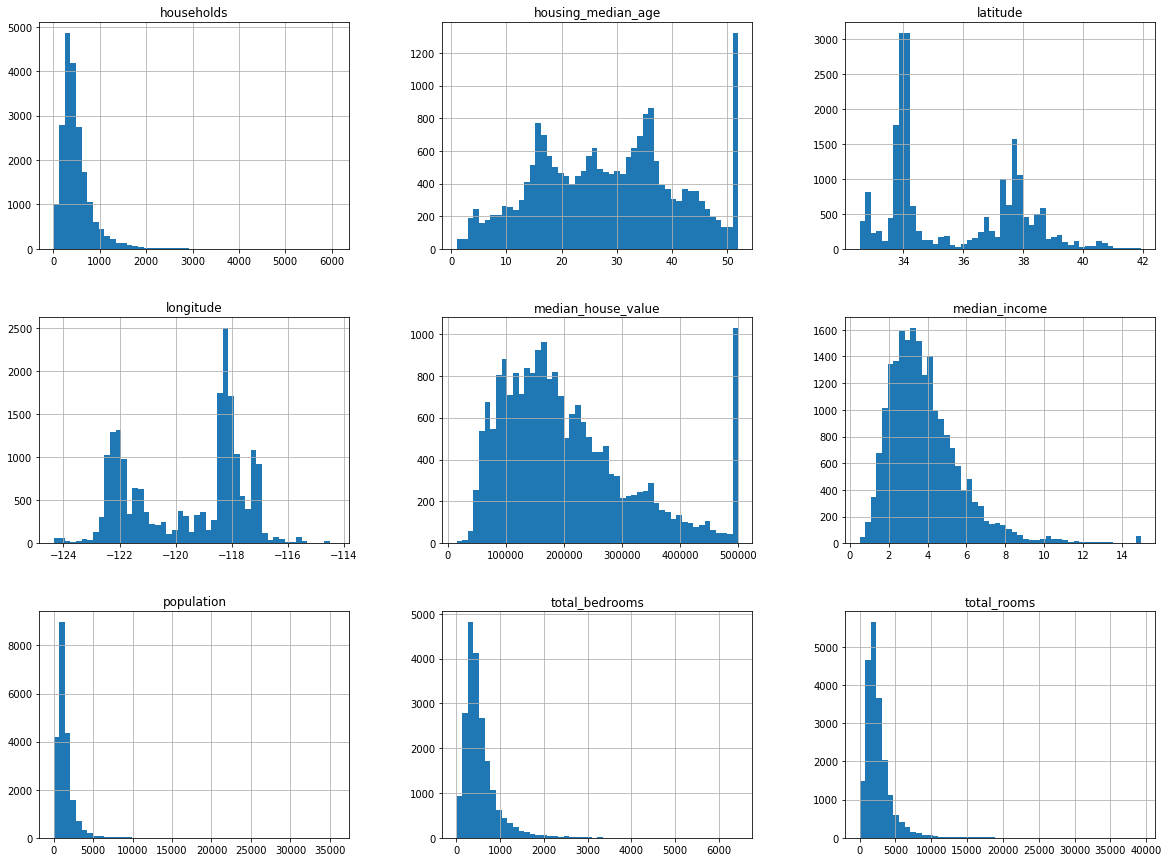

In [10]:
df.hist(bins=50, figsize=(20,15))
plt.show()

##**Divisão do dataset em duas partes, uma para o treinamento e outra para a validação final**

In [0]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

#**Começo da análise propriamente dita**


In [12]:
train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,NEAR OCEAN
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,INLAND


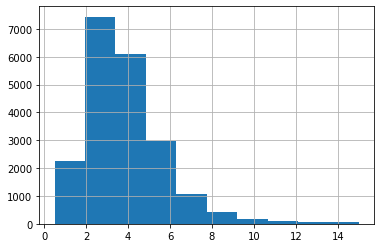

In [13]:
df["median_income"].hist()

In [0]:
df["income_cat"] = pd.cut(df["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [15]:
df["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

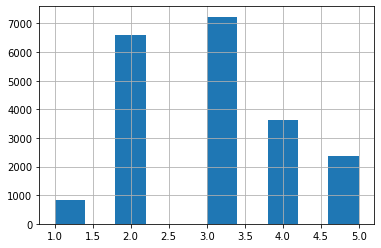

In [16]:
df["income_cat"].hist()

In [0]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["income_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [0]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [0]:
df = strat_train_set.copy()

Vamos agora dar uma olhada melhor nos nossos dados:

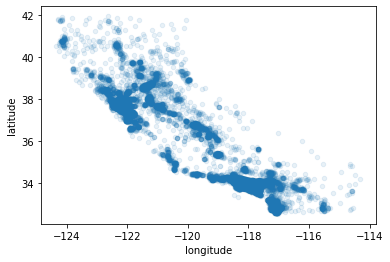

In [20]:
df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

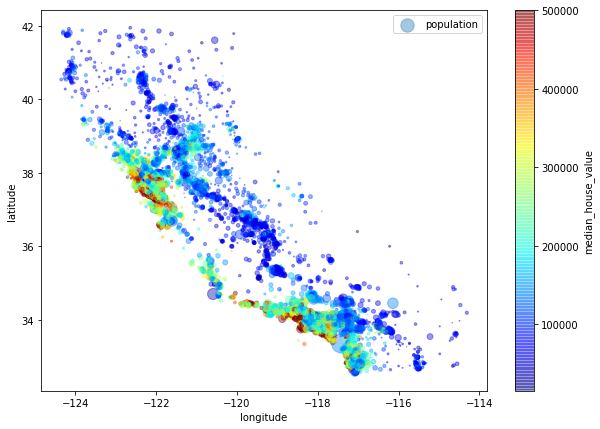

In [21]:
df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
        s=df["population"]/100, label="population", figsize=(10,7),
        c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
        sharex=False)
plt.legend()

In [22]:
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/end_to_end_project/california.png',
 <http.client.HTTPMessage at 0x7f2954d824a8>)

Saving figure california_housing_prices_plot


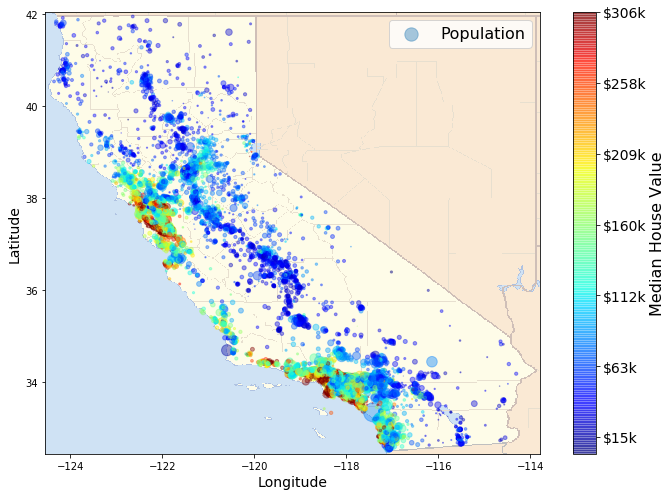

In [23]:
california_img=mpimg.imread(os.path.join(images_path, filename))
ax = df.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=df['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = df["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

In [0]:
matrix_corr = df.corr()

In [25]:
matrix_corr["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f29557694e0>,
      dtype=object)

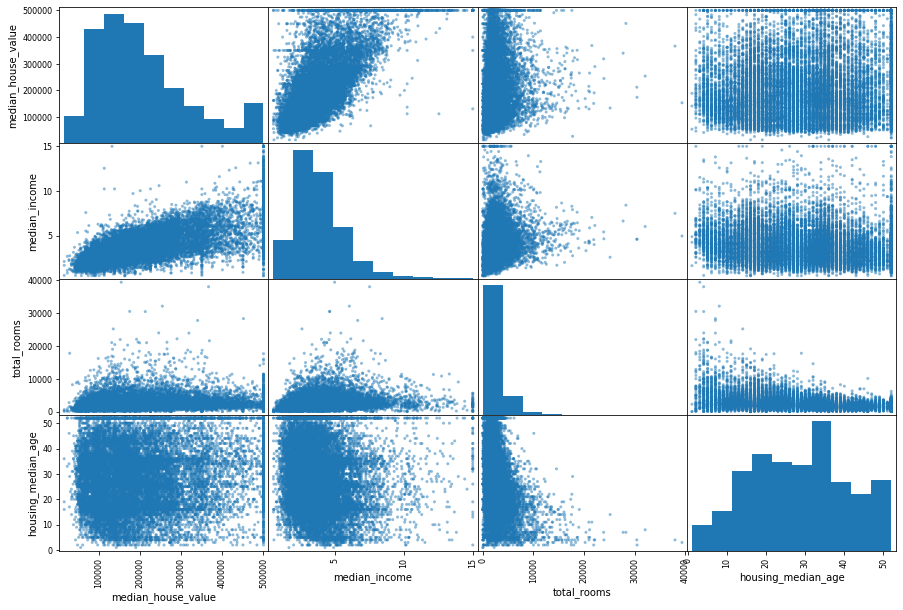

In [26]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(df[attributes], figsize=[15,10])

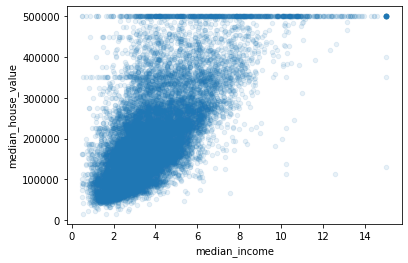

In [27]:
df.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

#**Limpeza de dados para o machine learning**

In [0]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
df_labels = strat_train_set["median_house_value"].copy()

In [0]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [0]:
df_num = housing.drop("ocean_proximity", axis=1)

In [0]:
X = imputer.fit_transform(df_num)

In [0]:
df_tr = pd.DataFrame(X, columns=df_num.columns,
                     index=df_num.index)

In [33]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


In [0]:
df_cat = df[["ocean_proximity"]]

In [35]:
df_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [0]:
cat_encoder = OneHotEncoder()
df_cat_1hot = cat_encoder.fit_transform(df_cat)

In [37]:
df_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [0]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [39]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
17606,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
18632,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
14650,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3230,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
3555,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


In [0]:
pipeline_num = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),])

df_num_tr = pipeline_num.fit_transform(df_num)

In [0]:
num_attribs = list(df_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
                                  ("num", pipeline_num, num_attribs),
                                  ("cat", OneHotEncoder(), cat_attribs)])
df_prepared = full_pipeline.fit_transform(df)

#**Pesquisa do melhor algoritmo para a predição**


In [0]:
def DisplayScores(scores):
  print("scores:", scores)
  print("mean", scores.mean())
  print("standard deviation:", scores.std())

In [0]:
lin_reg = LinearRegression()
lin_reg.fit(df_prepared, df_labels)
df_predictions = lin_reg.predict(df_prepared)

In [44]:
scores_lin_reg = cross_val_score(lin_reg, df_prepared, df_labels,
                         scoring="neg_mean_squared_error", cv=10)
Lin_reg_scores = np.sqrt(- scores_lin_reg)
DisplayScores(Lin_reg_scores)

scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
mean 69052.46136345083
standard deviation: 2731.674001798344


In [45]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(df_prepared, df_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [46]:
scores_tree = cross_val_score(tree_reg, df_prepared, df_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_scores = np.sqrt(- scores_tree)
DisplayScores(tree_scores)

scores: [70194.33680785 66855.16363941 72432.58244769 70758.73896782
 71115.88230639 75585.14172901 70262.86139133 70273.6325285
 75366.87952553 71231.65726027]
mean 71407.68766037929
standard deviation: 2439.4345041191004


In [47]:
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(df_prepared, df_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [48]:
scores_forest = cross_val_score(forest_reg, df_prepared, df_labels,
                         scoring="neg_mean_squared_error", cv=10)
forest_scores = np.sqrt(- scores_forest)
DisplayScores(forest_scores)

scores: [49519.80364233 47461.9115823  50029.02762854 52325.28068953
 49308.39426421 53446.37892622 48634.8036574  47585.73832311
 53490.10699751 50021.5852922 ]
mean 50182.303100336096
standard deviation: 2097.0810550985693


#**Fine-tune do melhor modelo encontrado**



In [49]:
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10, 30], 'max_features': [2, 3, 4, 8]},
  ]

forest_reg = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(df_prepared, df_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [50]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 8, 'n_estimators': 30}

In [51]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63669.11631261028 {'max_features': 2, 'n_estimators': 3}
55627.099719926795 {'max_features': 2, 'n_estimators': 10}
53384.57275149205 {'max_features': 2, 'n_estimators': 30}
60965.950449450494 {'max_features': 4, 'n_estimators': 3}
52741.04704299915 {'max_features': 4, 'n_estimators': 10}
50377.40461678399 {'max_features': 4, 'n_estimators': 30}
58663.93866579625 {'max_features': 6, 'n_estimators': 3}
52006.19873526564 {'max_features': 6, 'n_estimators': 10}
50146.51167415009 {'max_features': 6, 'n_estimators': 30}
57869.25276169646 {'max_features': 8, 'n_estimators': 3}
51711.127883959234 {'max_features': 8, 'n_estimators': 10}
49682.273345071546 {'max_features': 8, 'n_estimators': 30}
62895.06951262424 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54658.176157539405 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
52018.37891854505 {'bootstrap': False, 'max_features': 2, 'n_estimators': 30}
59470.40652318466 {'bootstrap': False, 'max_features': 3, 'n_estimator

In [52]:
param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=16),
    }
forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)

rnd_search.fit(df_prepared, df_labels)


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [53]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49150.70756927707 {'max_features': 7, 'n_estimators': 180}
51545.69893633704 {'max_features': 13, 'n_estimators': 15}
49759.92503903158 {'max_features': 11, 'n_estimators': 72}
51069.72321421702 {'max_features': 13, 'n_estimators': 21}
49280.9449827171 {'max_features': 7, 'n_estimators': 122}
50774.90662363929 {'max_features': 3, 'n_estimators': 75}
49724.34982649318 {'max_features': 11, 'n_estimators': 88}
49608.99608105296 {'max_features': 5, 'n_estimators': 100}
49121.43705778098 {'max_features': 8, 'n_estimators': 152}
50473.61930350219 {'max_features': 3, 'n_estimators': 150}


In [54]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.88273169e-02, 6.88671378e-02, 4.19942712e-02, 1.49017795e-02,
       1.35027000e-02, 1.37463931e-02, 1.38703967e-02, 3.65660516e-01,
       5.60550742e-02, 1.06803673e-01, 4.91984306e-02, 6.03551591e-03,
       1.65945461e-01, 5.87295283e-05, 1.75702503e-03, 2.77557978e-03])

In [55]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.36566051578935854, 'median_income'),
 (0.16594546121887757, 'INLAND'),
 (0.10680367278788902, 'pop_per_hhold'),
 (0.0788273168564426, 'longitude'),
 (0.06886713775077481, 'latitude'),
 (0.056055074188628866, 'rooms_per_hhold'),
 (0.049198430598853135, 'bedrooms_per_room'),
 (0.041994271206875156, 'housing_median_age'),
 (0.0149017794968775, 'total_rooms'),
 (0.013870396699546922, 'households'),
 (0.013746393149146328, 'population'),
 (0.013502700011651837, 'total_bedrooms'),
 (0.006035515910948288, '<1H OCEAN'),
 (0.002775579776224739, 'NEAR OCEAN'),
 (0.0017570250296167335, 'NEAR BAY'),
 (5.872952828798226e-05, 'ISLAND')]

#**Validação do modelo no set que foi reservado do treinamento**

In [0]:
final_model = grid_search.best_estimator_

y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(strat_test_set)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)



In [57]:
print(final_rmse)

46994.8202174666
